In [1]:
# gán cả file audio to thành 10101010 dựa vào file labs rồi chia audio và chia chuỗi 1010 mới tạo tương ứng
# cứ 2s tương ứng 115 frame nghĩa là cứ 2s tương ứng 115 số (0 hoặc 1), 0 là không có âm thanh, 1 là có âm thanh
# x [1, 1, 32000]
# y [115] stride = 10
# convert từ file lab ra chuỗi 1010

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torchaudio
from sincnet_template import SincNet
from einops import rearrange
import os 

In [3]:
# Read label names
labels = sorted(os.listdir('train-data/label'))
print('len(labels) =', len(labels)) # 93

len(labels) = 93


In [4]:
# Read (start_time, end_time) of speech into speech list
def read_label(labels):
    speech = []
    for label in labels:
        speechi = []
        f = open(f'train-data/label/{label}', 'r')
        for x in f:
            x = x.split()
            speechi.append((float(x[0]), float(x[1])))
        speech.append(speechi)
    return speech
speech = read_label(labels)
print('len(speech) =', len(speech)) # 93
print('len(speech[0] =', len(speech[0])) # 439 (start, end)

len(speech) = 93
len(speech[0] = 439


In [5]:
# Write the number of 2-second audio files in each audio after splitting
file_each_folder = [2625, 1725, 1773, 2034, 1120, 1722, 2707, 1762, 1526, 1237, 1549, 2662, 
636, 1139, 1211, 1312, 569, 1054, 1128, 1175, 238, 1156, 1147, 865, 642, 1091, 1090, 983, 603, 842, 1188, 624, 521, 1115, 1051, 1312, 701, 717, 978, 1057, 322, 875, 918, 552, 1119, 1104, 474, 412, 1064, 1179, 949, 574, 1159, 1136, 1455, 573, 1147, 1067, 965, 692, 1206, 1154, 761, 
791, 1171, 1057, 1309, 454, 1058, 722, 390, 1183, 1040, 631, 456, 823, 938, 1050, 
398, 1090, 1131, 982, 512, 1091, 1030, 425, 1080, 975, 919, 483, 651, 1056, 1014]
print('len(file_each_folder) =', len(file_each_folder)) # 93
print('sum(file_each_folder) =', sum(file_each_folder)) # 95354

len(file_each_folder) = 93
sum(file_each_folder) = 95354


In [6]:
# Convert (start_time, end_time) to Y 10101010...
Y = torch.tensor([])
for i in range(len(labels)):
    bit_length = file_each_folder[i] * 115
    label = torch.zeros(bit_length)
    for j in range(len(speech[i])):
        start_time = speech[i][j][0]
        end_time = speech[i][j][1]
        start_index = int(start_time * 115 / 2) - 1 # 0 - 114
        end_index = int(end_time * 115 / 2) - 1
        for l in range(start_index, end_index + 1):
                label[l] = 1
    Y = torch.cat((Y, label))

In [7]:
# Reshape Y
Y = torch.reshape(Y, (95354, 115, 1))
Y.shape

torch.Size([95354, 115, 1])

In [8]:
# Set key for sorting
import re 
def by_index(string_name):
    number_list = re.findall(r'\d+', string_name)
    char_1 = string_name[:2]
    number_0 = int(number_list[0])
    number_1 = int(number_list[1])
    char_2 = string_name[6]
    return (char_1, number_0, char_2, number_1)

In [9]:
# Read all audio file names
import os
audio_file_names = sorted(os.listdir('train-data/audio'), key=by_index)
print('len(audio_file_names) =', len(audio_file_names)) # 95354

len(audio_file_names) = 95354


In [10]:
# sn = SincNet(stride=10)
# waveform, sample_rate = torchaudio.load('audio-all/EN2001a.Mix-Headset.wav_0.wav')
# print(waveform.shape)
# output = sn(waveform.unsqueeze(1))
# print(output.shape)
# a = rearrange(output, "batch feature frame -> batch frame feature")
# print(a.shape)
# lstm = nn.LSTM(60, 128, 2, bidirectional=True)
# b = lstm(a)
# b[0].shape
# ln = nn.Linear(256, 128)
# c = ln(b[0])
# c.shape
# ln2 = nn.Linear(128, 1)
# d = ln2(c)
# print(d.shape)
# sm = nn.Sigmoid()
# e = sm(d)
# e.shape
# print(e.shape)

In [11]:
# Prepare dataloader
import torch
from torch.utils.data import Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, audio_file_names, Y):
        self.audio_file_names = audio_file_names
        self.Y = Y

    def __len__(self):
        return len(self.audio_file_names)

    def __getitem__(self, idx):
        return audio_file_names[idx], Y[idx]

In [13]:
data = CustomDataset(audio_file_names, Y)

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(data, batch_size=8, shuffle=True)

In [15]:
train_features, train_labels = next(iter(train_dataloader))

In [16]:
print(f"Feature batch shape: {len(train_features)}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: 8
Labels batch shape: torch.Size([8, 115, 1])


In [17]:
# Model
class VADModel(nn.Module):
    def __init__(self):
        super(VADModel, self).__init__()
        self.sn = SincNet(stride=10)
        self.lstm = nn.LSTM(60, 128, 2, bidirectional=True)
        self.ln1 = nn.Linear(256, 128)
        self.ln2 = nn.Linear(128, 1)
        self.sm = nn.Sigmoid()
    def forward(self, waveform):
        output = self.sn(waveform.unsqueeze(1))
        output = rearrange(output, "batch feature frame -> batch frame feature")
        output = self.lstm(output)
        output = self.ln1(output[0])
        output = self.ln2(output)
        output = self.sm(output)
        return output

In [18]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [19]:
# Get device
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [20]:
import torch.optim as optim

# Instantiate the model
model = VADModel().to(device)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01) # momentum=0.9

# Define loss using a predefined loss function
criterion = nn.BCELoss().to(device)

In [21]:
# Model summary
# from torchinfo import summary

# model = VADModel()
# summary(model, input_size=(1, 32000))

In [22]:
# Training
n_epoch = 10
best_loss = 1e9
checkpoint_interval = 5
for epoch in range(n_epoch):
    running_loss = 0.0
    for batch, (X, y) in enumerate(train_dataloader):
        # get the inputs and the labels
        waveforms = []
        for i in range(len(X)):
            waveform, sample = torchaudio.load(f'train-data/audio/{X[i]}')
            waveforms.append(waveform)
        Xshape = torch.Tensor(len(X), 1, 32000)
        X = torch.cat(waveforms, out=Xshape)
        X = X.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        y_pred = model(X)
        loss = criterion(y_pred.to(device), y.view(len(y), 115, 1))
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if batch % checkpoint_interval == checkpoint_interval-1:
            print(f'[{epoch+1}, {batch+1}] loss: {running_loss/checkpoint_interval}')
            loss = running_loss/checkpoint_interval
            if loss < best_loss:
                best_loss = loss
                torch.save({
                    "epoch": epoch,
                    "loss": best_loss,
                    "model": model
                }, '/home/duongvt/duccd/VAD/cp_10_8_0.01_loss_301122_1.pt')
                print(best_loss)
            running_loss = 0.0

[1, 5] loss: 0.692725419998169
0.692725419998169
[1, 10] loss: 0.6846141815185547
0.6846141815185547
[1, 15] loss: 0.6745157718658448
0.6745157718658448
[1, 20] loss: 0.6621465563774109
0.6621465563774109
[1, 25] loss: 0.6542686581611633
0.6542686581611633
[1, 30] loss: 0.656943428516388
[1, 35] loss: 0.6706740736961365
[1, 40] loss: 0.6435847282409668
0.6435847282409668
[1, 45] loss: 0.6177641391754151
0.6177641391754151
[1, 50] loss: 0.6050422668457032
0.6050422668457032
[1, 55] loss: 0.6019399762153625
0.6019399762153625
[1, 60] loss: 0.6141575813293457
[1, 65] loss: 0.6066416144371033
[1, 70] loss: 0.5960424184799195
0.5960424184799195
[1, 75] loss: 0.5619458794593811
0.5619458794593811
[1, 80] loss: 0.5974237084388733
[1, 85] loss: 0.5694379448890686
[1, 90] loss: 0.5973560690879822
[1, 95] loss: 0.5601034998893738
0.5601034998893738
[1, 100] loss: 0.5392226040363312
0.5392226040363312
[1, 105] loss: 0.5479424595832825
[1, 110] loss: 0.5751896262168884
[1, 115] loss: 0.62728101015

In [26]:
# Load checkpoint
model_load = torch.load('cp_10_8_0.01_loss_301122_1.pt')

In [27]:
model_load['loss']

0.07515870407223701

In [ ]:
# Chưa Code Infer

In [25]:
waveform, sample_rate = torchaudio.load('train-data/audio/EN2001a.Mix-Headset.wav_7.wav')
output = model_load['model'](waveform.to(device))
output = output[:, :, -1]
print(output.shape)
target = Y[7]
print(target.shape)
print(target)
print(output)
from torchmetrics.classification import BinaryAUROC
metric = BinaryAUROC(thresholds=None)
metric(output, target)

torch.Size([1, 115])
torch.Size([115, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

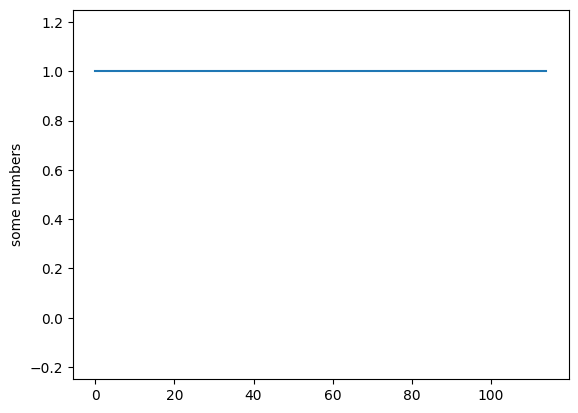

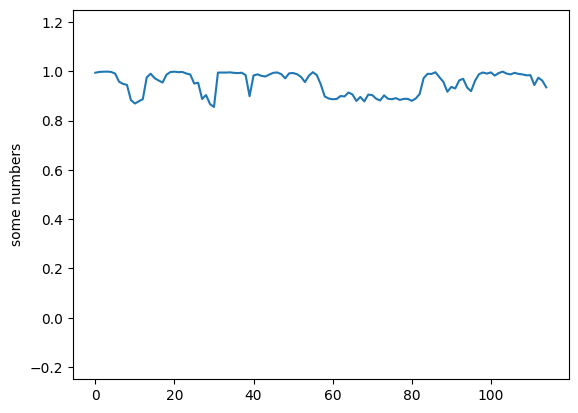

In [ ]:
# Inference
waveform, sample_rate = torchaudio.load('train-data/audio/EN2001a.Mix-Headset.wav_300.wav')
output = model_load['model'](waveform.to(device))
# print(output)

import matplotlib.pyplot as plt

# plt.plot(Y[14].flatten().detach().numpy())
plt.plot(Y[300].flatten().numpy())
plt.ylabel('some numbers')
plt.ylim(-0.25,1.25)
plt.show()

import matplotlib.pyplot as plt

plt.plot(output.flatten().detach().cpu())
plt.ylabel('some numbers')
plt.ylim(-0.25,1.25)
plt.show()

In [ ]:
import os

audio_file_names_valid = sorted(os.listdir('validation-data/audio'), key=by_index)
print('len(audio_file_names_valid) =', len(audio_file_names_valid))

len(audio_file_names_valid) = 659


In [ ]:
y_pred = torch.tensor([])
for name in audio_file_names_valid:
    waveform, sample_rate = torchaudio.load(f'validation-data/audio/{name}')
    output = model_load['model'](waveform)[0, :, 0]
    y_pred = torch.cat((y_pred, output))

: 

: 